# Imports
Below is a list of all the packages used in the project

In [ ]:
import string
import re
import json
import pickle
import warnings
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from keras.models import load_model
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Activation, Dropout, GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
import random

from matplotlib import pyplot as plt

## Data Preparation
The dataset is in json format and so to make it more visually appealing it's better to convert it to a Pandas dataframe format. This will also later on make it easy for us to do some data analysis.


In [ ]:
# read the dataset
with open('/content/drive/MyDrive/Datasets/Mental Health/intents.json', 'r') as f:
    data = json.load(f)

# Convert dataset into dataframe
df = pd.DataFrame(data['intents'])

# preview of dataset
df


,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."
...,...,...,...
75,fact-28,[What do I do if I'm worried about my mental h...,[The most important thing is to talk to someon...
76,fact-29,[How do I know if I'm unwell?],"[If your beliefs , thoughts , feelings or beha..."
77,fact-30,[How can I maintain social connections? What i...,"[A lot of people are alone right now, but we d..."
78,fact-31,[What's the difference between anxiety and str...,[Stress and anxiety are often used interchange...


On the datafram each tag contains a list of question(pattern) and answers(responses). The below code breaks up the patterns based on their tag and responses and reconvert them into a DataFrame

In [ ]:
dic = {"tag":[], "patterns":[], "responses":[]}
count = 1

for i in range(len(df)):
    patterns = df[df.index == i]['patterns'].values[0]
    responses = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]

    for j in range(len(patterns)):
        dic['tag'].append(tag)
        dic['patterns'].append(patterns[j])
        dic['responses'].append(responses)


df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [ ]:
# preview of tag (label) in the dataset
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no-response', 'neutral-response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not-talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate-you',
       'hate-me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something-else', 'friends', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user-meditation', 'pandora-useful', 'user-advice',
       'learn-mental-health', 'mental-health-fact', 'fact-1', 'fact-2',
       'fact-3', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9',
       'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15',
       'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-20', 'fact-21',
       'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27',
       'fact-28', 'fact-29', '

# Exploratory Data Analysis



### Distribution of Intents
Below we analyze the distribution of intents in the dataset and visualize this data using bar plot from the Matplotlib library. The x-axis represents the intents, and y-axis represent the count of patterns or responses associated with each intent

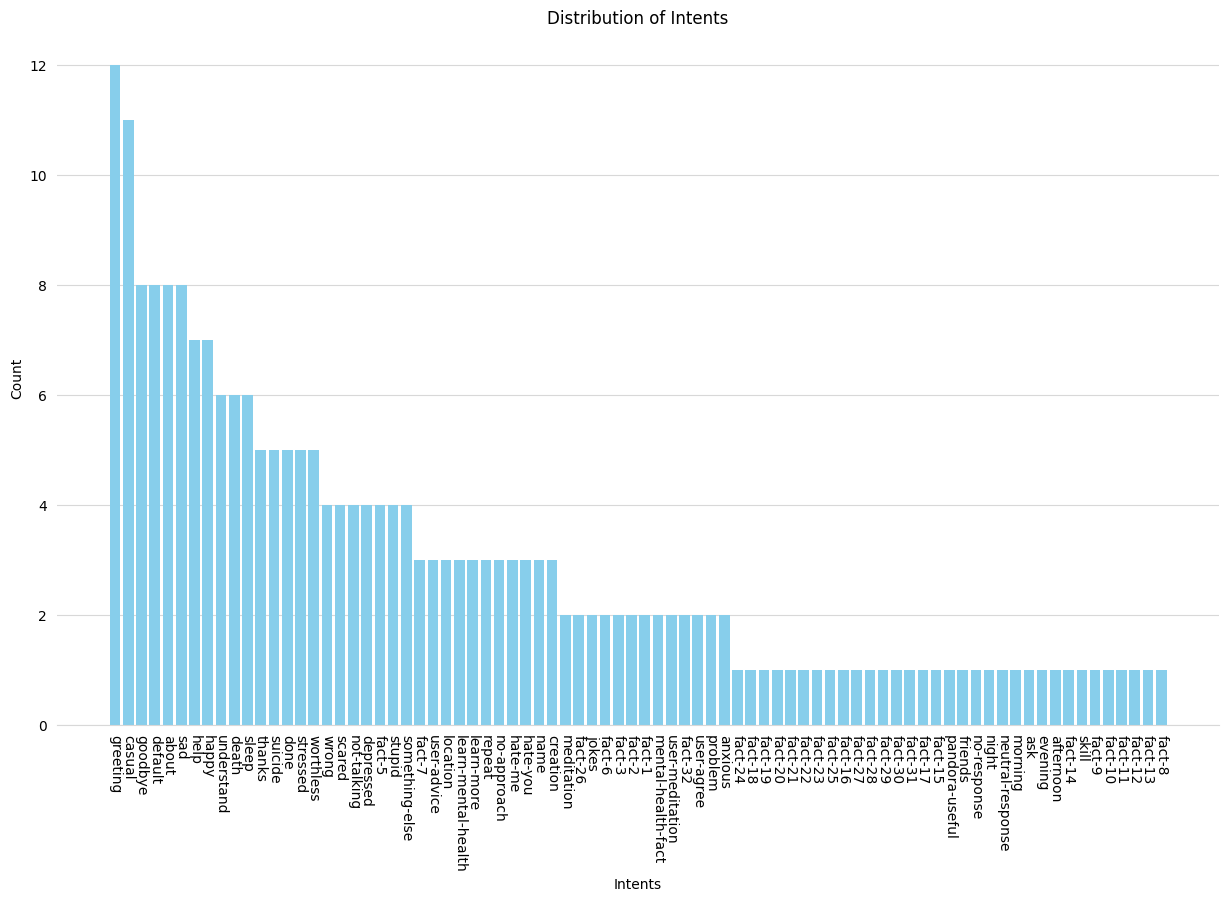

In [ ]:
intents_count = df['tag'].value_counts()

fig, ax= plt.subplots(figsize=(15,9))
ax.bar(intents_count.index, intents_count.values, color='skyblue')
plt.xticks(rotation=-90)
plt.xlabel('Intents')
plt.ylabel('Count')
plt.title('Distribution of Intents')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#D8D8D8')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.xaxis.grid(False)
ax.yaxis.grid(True, color='#D8D8D8')

plt.savefig('distribution_analysis.png')
plt.show()

### Pattern and Response Analysis

Below we explore the patterns and responses associated with each intent then we make use of Matplotlib library to visualize the information. X-axis represents the avearge count of patterns and responses and the y-axis represents the intents.

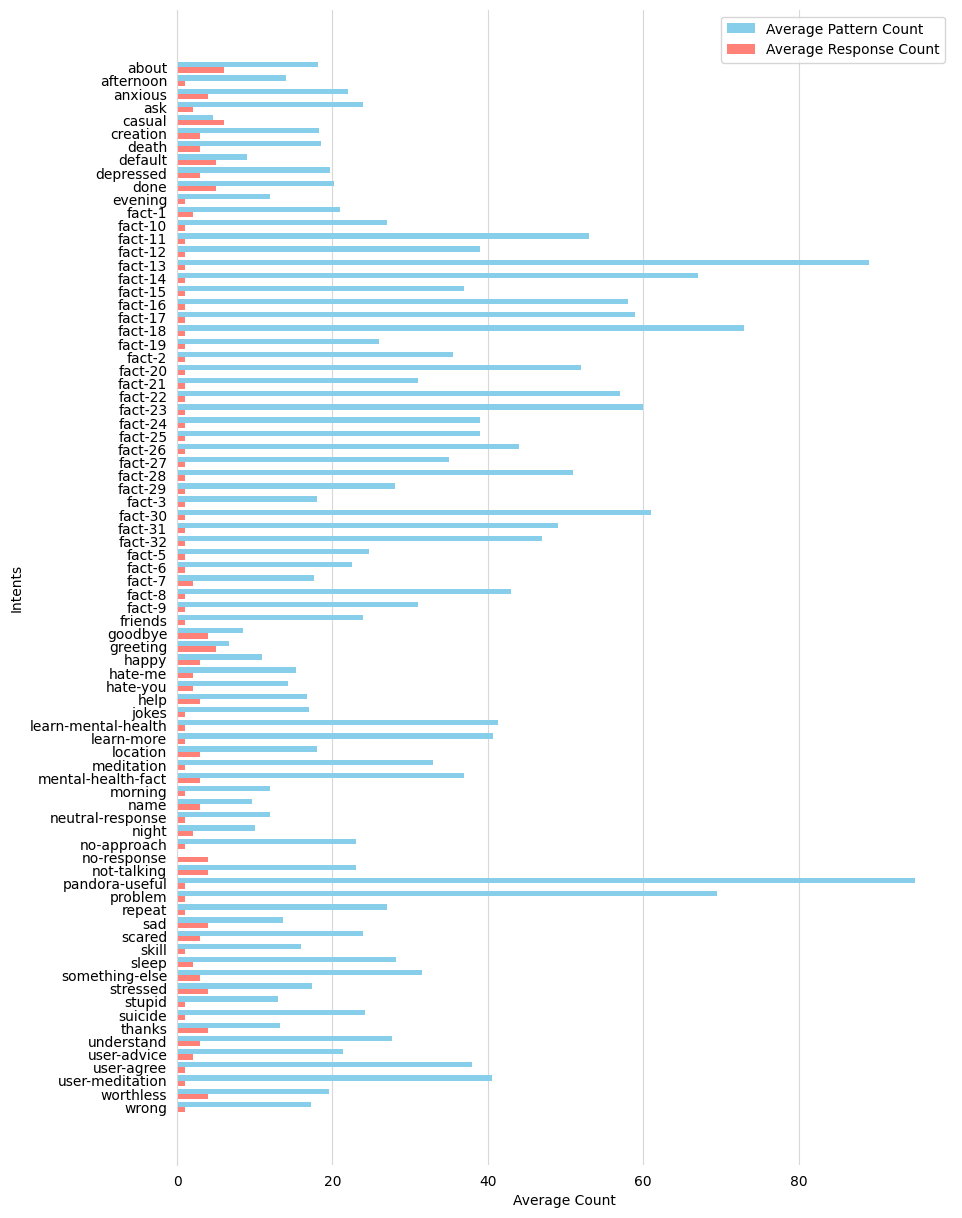

In [ ]:
# get the str length of each pattern under patterns
df['pattern_count'] = df['patterns'].apply(lambda x: len(x))

# get the list length of each reponse list under responses
df['response_count'] = df['responses'].apply(lambda x: len(x))

# get the average pattern_count and response_count
avg_pattern_count = df.groupby('tag')['pattern_count'].mean()
avg_response_count = df.groupby('tag')['response_count'].mean()

# plot chart
X_axis = np.arange(len(avg_pattern_count.index))
fig, ax= plt.subplots(figsize=(10,15))

ax.barh(X_axis - 0.4, avg_pattern_count.values, align='edge', height=0.4, label= 'Average Pattern Count', color='skyblue')
ax.barh(X_axis, avg_response_count.values, align='edge', height=0.4, label= 'Average Response Count', color='#ff8178')
ax.invert_yaxis()

# Style chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('#D8D8D8')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, color='#D8D8D8')

plt.yticks(X_axis, avg_pattern_count.index)
plt.ylabel(ylabel='Intents')
plt.xlabel('Average Count')
ax.legend()

plt.savefig('ptrn_rspn_analysis.png')
plt.show()

# Data Preprocessing

Now will be apply some text preprocessing techniques such as cleaning/ normalizing, lowering, removing punctuations and then tokenizing the patterns.



In [ ]:
lemmatizer = WordNetLemmatizer()
words = []
classes = []
documents = []
ignore_words = string.punctuation

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# This function converts short-hand texts to long format
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", " will not", txt)
    txt = re.sub(r"can't", " can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

# the the pattern text and normalize it
for i in range(len(df)):
  pattern = clean_text(df['patterns'][i])
  df['patterns'][i] = pattern

df

<ipython-input-34-25cb1354567a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['patterns'][i] = pattern


,tag,patterns,responses,pattern_count,response_count
0,greeting,hi,[Hello there. Tell me how are you feeling toda...,2,5
1,greeting,hey,[Hello there. Tell me how are you feeling toda...,3,5
2,greeting,is anyone there,[Hello there. Tell me how are you feeling toda...,16,5
3,greeting,hi there,[Hello there. Tell me how are you feeling toda...,8,5
4,greeting,hello,[Hello there. Tell me how are you feeling toda...,5,5
...,...,...,...,...,...
227,fact-29,how do i know if i am unwell,"[If your beliefs , thoughts , feelings or beha...",28,1
228,fact-30,how can i maintain social connections what if ...,"[A lot of people are alone right now, but we d...",61,1
229,fact-31,what is the difference between anxiety and stress,[Stress and anxiety are often used interchange...,49,1
230,fact-32,what is the difference between sadness and dep...,"[Sadness is a normal reaction to a loss, disap...",53,1


In [ ]:
# Tokenization
for i, pattern in df['patterns'].items():
  w = nltk.word_tokenize(pattern)
  words.extend(w)
  documents.append((w, df['tag'][i]))

  # add the tag in our classes list
  if df['tag'][i] not in classes:
    classes.append(df['tag'][i])

In [ ]:
# Lemmatization
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

# documents = combination between patterns and intents
print (len(documents), "documents\n", documents, "\n")
# classes = intents[tag]
print (len(classes), "classes\n", classes, "\n")
# words = all words, vocabulary
print (len(words), "unique lemmatized words\n", words, "\n")

# Extract the words and classes to a pkl file
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

232 documents
 [(['hi'], 'greeting'), (['hey'], 'greeting'), (['is', 'anyone', 'there'], 'greeting'), (['hi', 'there'], 'greeting'), (['hello'], 'greeting'), (['hey', 'there'], 'greeting'), (['howdy'], 'greeting'), (['hola'], 'greeting'), (['bonjour'], 'greeting'), (['konnichiwa'], 'greeting'), (['guten', 'tag'], 'greeting'), (['ola'], 'greeting'), (['good', 'morning'], 'morning'), (['good', 'afternoon'], 'afternoon'), (['good', 'evening'], 'evening'), (['good', 'night'], 'night'), (['bye'], 'goodbye'), (['see', 'you', 'later'], 'goodbye'), (['goodbye'], 'goodbye'), (['au', 'revoir'], 'goodbye'), (['sayonara'], 'goodbye'), (['ok', 'bye'], 'goodbye'), (['bye', 'then'], 'goodbye'), (['fare', 'thee', 'well'], 'goodbye'), (['thanks'], 'thanks'), (['thank', 'you'], 'thanks'), (['that', 'is', 'helpful'], 'thanks'), (['thanks', 'for', 'the', 'help'], 'thanks'), (['than', 'you', 'very', 'much'], 'thanks'), ([], 'no-response'), (['nothing', 'much'], 'neutral-response'), (['who', 'are', 'you'], 

# Build and Train Model

In [ ]:
training = [] # For training data

output_empty = [0] * len(classes) # This is for our output


# Training set, bag of wards for each sentence
for doc in documents:
  bag_of_words = []
  pattern_words = doc[0]
  # lemmatize and convert pattern_words to lower case
  pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

  # create bag of words array,if word match found in current pattern then put 1
  # otherwise 0.[row * colm(263)]
  for w in words:
    bag_of_words.append(1) if w in pattern_words else bag_of_words.append(0)

  # in output array 0 value for each tag ang 1 value for matched tag.[row *
  # colm(8)]
  output_row = list(output_empty)
  output_row[classes.index(doc[1])] = 1

  training.append([bag_of_words, output_row])

random.shuffle(training)
training = np.array(training, dtype=list)

# create the traing and test.
train_x = list(training[:,0]) # patterns(words)
train_y = list(training[:,1]) # intents(tag)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 128)               37504     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 80)                5200      
                                                                 
Total params: 50960 (199.06 KB)
Trainable params: 50960 (199.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


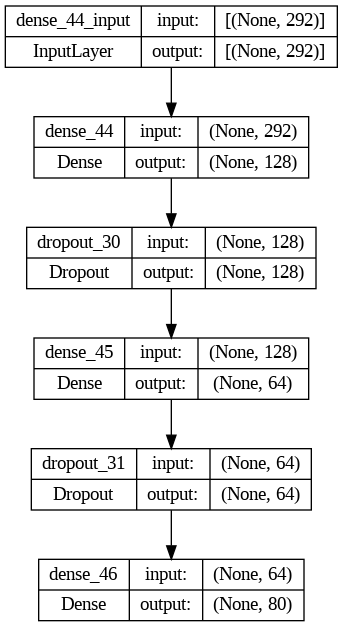

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu')) # Layer 1 - 128 neurons
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu')) # Layer 2 - 64 neurons
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient
# gives good results for this model
sgd = SGD(learning_rate=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

Epoch 1/1500
47/47 [==============================] - 1s 3ms/step - loss: 4.3984 - accuracy: 0.0172
Epoch 2/1500
47/47 [==============================] - 0s 3ms/step - loss: 4.2976 - accuracy: 0.0733
Epoch 3/1500
47/47 [==============================] - 0s 3ms/step - loss: 4.2404 - accuracy: 0.0733
Epoch 4/1500
47/47 [==============================] - 0s 3ms/step - loss: 4.0870 - accuracy: 0.1078
Epoch 5/1500
47/47 [==============================] - 0s 3ms/step - loss: 3.9211 - accuracy: 0.1164
Epoch 6/1500
47/47 [==============================] - 0s 4ms/step - loss: 3.7904 - accuracy: 0.1207
Epoch 7/1500
47/47 [==============================] - 0s 3ms/step - loss: 3.6519 - accuracy: 0.1509
Epoch 8/1500
47/47 [==============================] - 0s 3ms/step - loss: 3.5340 - accuracy: 0.1595
Epoch 9/1500
47/47 [==============================] - 0s 3ms/step - loss: 3.3510 - accuracy: 0.2284
Epoch 10/1500
47/47 [==============================] - 0s 4ms/step - loss: 3.1875 - accuracy: 0.2112

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


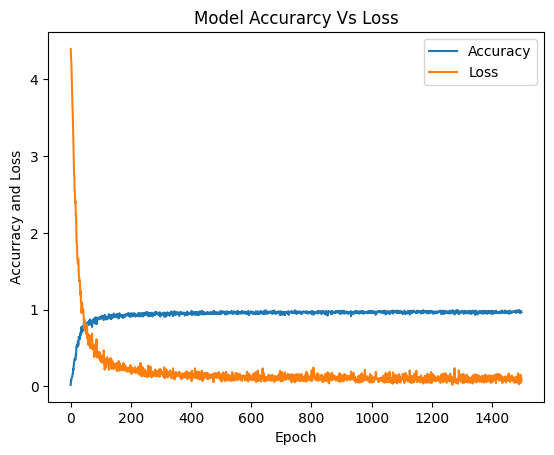

In [ ]:
history = model.fit(train_x, train_y, epochs=1500, batch_size=5, verbose=1)
model.save('model.h5', history)

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accurarcy Vs Loss')
plt.ylabel('Accurracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'])
plt.savefig('train_stats.png')
plt.show()


In [ ]:
print(np.mean(history.history['loss']))
print(np.mean(history.history['accuracy']))

0.20325816126167776
0.938287355709821


# Chatbot

In [ ]:
model = load_model('/content/model.h5')

intents = json.loads(open('/content/drive/MyDrive/Datasets/Mental Health/intents.json').read())

words = pickle.load(open('/content/words.pkl','rb'))

classes = pickle.load(open('/content/classes.pkl','rb'))

lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words


def bow(sentence, words, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    print(sentence_words)

    bag = [0]*len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
                if show_details:
                    print("found in bag: %s" % w)

    return np.array(bag)


def predict_class(sentence, model):
    p = bow(sentence, words, show_details=False)
    print(p)

    res = model.predict(np.array([p]))[0]
    print(res)

    ERROR_THRESHOLD = 0.25

    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    print(results)

    results.sort(key=lambda x: x[1], reverse=True)
    print(results)

    return_list = []

    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})

    return return_list

In [ ]:
def getResponse(ints, intents_json):

    tag = ints[0]['intent']
    #print(tag)

    list_of_intents = intents_json['intents']
    #print(list_of_intents)

    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result


def chatbot_response(text):
    ints = predict_class(text, model) #print(ints)

    res = getResponse(ints, intents)
    print(res)
    return res


In [ ]:
start = True
print('Start chatting to Ixias.')
while start:

    query = input('User:')
    if query in ['quit','exit','bye']:
        start = False
        continue
    try:
      res = chatbot_response(query)
      print(res)
    except:
        print('Oops! Did not catch your statment, please rephrase.')

Start chatting to Ixias.
User:Afternoon
['afternoon']
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 127ms/step
[3.2112057e-15 9.9999380e-01 2.7652412e-18 7.6448937e-19 1.7692899e-09
 2.1587408e-15 8.6804768e-16 4.7930944e-06 1.0711574e-20 1.2008323e-16
 3.1699051e-07 1.0941405e-19 4.7948825e-13 2.0410519e-13 1.4493328e-14
 6.3982020e-20 1.6086276e-15 9.2620243e-12 5.8877924e-13 2.6696640e-14
 2.0592436e-12 1